<a href="https://colab.research.google.com/github/JWNLP/classification/blob/main/%5B3%5D%20%5BDBPedia%5D%20acc%20%3D%2099%2C%20max-length%20%3D%20256%2C%20learning-rate%20%3D%205e-5%2C%20drop-out%20%3D%200.3%2C%20epochs%20%3D%204%2C%20batch-size%20%3D32.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## dbpedia_csv

> 
train_data = pd.read_csv("/content/drive/MyDrive/dbpedia_csv/train.csv", delimiter=',', header=None, names=['label', 'sentence'])

test_data = pd.read_csv("/content/drive/MyDrive/dbpedia_csv/test.csv", delimiter=',', header=None, names=['label', 'sentence'])




In [42]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [43]:
pip install transformers


pip install pyspark


pip install matplotlib

In [44]:
pip install matplotlib

In [45]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [46]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import random
import nltk
from nltk.corpus import stopwords 
from tqdm import tqdm

import argparse
import easydict

import warnings
warnings.filterwarnings('ignore')

In [47]:
DATA_TRAIN_PATH = "/content/drive/MyDrive/dbpedia_csv/train.csv"
DATA_TEST_PATH = "/content/drive/MyDrive/dbpedia_csv/test.csv"


In [48]:
"""
parser = argparse.ArgumentParser()
parser.add_argument('-seed', default=0, type=int)
parser.add_argument('-max_seq_length', default=512, type=int)
parser.add_argument('-batch_size', default=24, type=int)
parser.add_argument('-num_epochs', default=4, type=int)
parser.add_argument('-learning_rate', default=2e-5, type=float)
parser.add_argument('-max_grad_norm', default=1.0, type=float)
parser.add_argument('-warm_up_proportion', default=0.1, type=float)
parser.add_argument('-gradient_accumulation_step', default=1, type=int)
parser.add_argument('-bert_path', default='bert-base-uncased')
parser.add_argument('-trunc_mode', default=128, type=str)
args = parser.parse_args()
"""

"\nparser = argparse.ArgumentParser()\nparser.add_argument('-seed', default=0, type=int)\nparser.add_argument('-max_seq_length', default=512, type=int)\nparser.add_argument('-batch_size', default=24, type=int)\nparser.add_argument('-num_epochs', default=4, type=int)\nparser.add_argument('-learning_rate', default=2e-5, type=float)\nparser.add_argument('-max_grad_norm', default=1.0, type=float)\nparser.add_argument('-warm_up_proportion', default=0.1, type=float)\nparser.add_argument('-gradient_accumulation_step', default=1, type=int)\nparser.add_argument('-bert_path', default='bert-base-uncased')\nparser.add_argument('-trunc_mode', default=128, type=str)\nargs = parser.parse_args()\n"

In [49]:
args = easydict.EasyDict({
        "seed": 42,
        "max_seq_length": 256,
        "batch_size": 32,
        "num_epochs": 4,
        "num_labels":14,
        "learning_rate":5e-5,
        "adam_epsilon":1e-8,
        "attention_probs_dropout_prob" : 0.3,
        "hidden_dropout_prob" : 0.3,
       
        "max_grad_norm": 1.0,
        "warm_up_proportion": 0.1,
        "gradient_accumulation_step": 1,
        "bert_path": 'bert-base-uncased',
        "trunc_mode": 128
         
})

In [50]:

# Load the dataset into a pandas dataframe.
train_data = pd.read_csv(DATA_TRAIN_PATH,  delimiter=',', header=None, names=['label', 'title', 'description'], encoding='utf8')
#test_data = pd.read_csv("/content/drive/MyDrive/yelp_review_full_csv/test.csv",  nrows = 3000, delimiter=',', header=None, names=['index', 'sentence'])


# Report the number of sentences.
print('Number of training sentences: {:,}\n'.format(train_data.shape[0]))
#print('Number of test sentences: {:,}\n'.format(test_data.shape[0]))

# Display 10 random rows from the data.
#train_data.head()
train_data = train_data.sample(n=3000,random_state=1)
train_data.head()
#df.sample(10)


Number of training sentences: 560,000



,label,title,description
39658,1,Daisy Systems,Daisy Systems Corporation incorporated in 198...
330033,9,Rutki-Kossaki,Rutki-Kossaki [ˈrutki kɔsˈsaki] is a village ...
238898,6,USS Mecosta (YTB-818),USS Mecosta (YTB-818) was a United States Nav...
453536,12,So Many Partings,So Many Partings is an album by Silly Wizard ...
555973,14,Five Go Down to the Sea,Five Go Down To The Sea is the twelfth novel ...


In [51]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3000 entries, 39658 to 5080
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   label        3000 non-null   int64 
 1   title        3000 non-null   object
 2   description  3000 non-null   object
dtypes: int64(1), object(2)
memory usage: 93.8+ KB


In [52]:
'''
train_data['label_1'] = train_data[train_data.label ==1]
label_2 = train_data[train_data.label ==2]
label_3 = train_data[train_data.label ==3]
label_4 = train_data[train_data.label ==4]
label_5 = train_data[train_data.label ==5]
label_6 = train_data[train_data.label ==6]
label_7 = train_data[train_data.label ==7]
label_8 = train_data[train_data.label ==8]
label_9 = train_data[train_data.label ==9]
label_10 = train_data[train_data.label ==10]
label_11 = train_data[train_data.label ==11]
label_12 = train_data[train_data.label ==12]
label_13 = train_data[train_data.label ==13]
label_14 = train_data[train_data.label ==14]
'''

"\ntrain_data['label_1'] = train_data[train_data.label ==1]\nlabel_2 = train_data[train_data.label ==2]\nlabel_3 = train_data[train_data.label ==3]\nlabel_4 = train_data[train_data.label ==4]\nlabel_5 = train_data[train_data.label ==5]\nlabel_6 = train_data[train_data.label ==6]\nlabel_7 = train_data[train_data.label ==7]\nlabel_8 = train_data[train_data.label ==8]\nlabel_9 = train_data[train_data.label ==9]\nlabel_10 = train_data[train_data.label ==10]\nlabel_11 = train_data[train_data.label ==11]\nlabel_12 = train_data[train_data.label ==12]\nlabel_13 = train_data[train_data.label ==13]\nlabel_14 = train_data[train_data.label ==14]\n"

In [53]:
train_data.value_counts()

label  title                   description                                                                                                                                                                                                                                                                                                                                                                                                                                             
14     Yummy Fur (comics)       Yummy Fur (1983–1994) was a comic book by Canadian cartoonist Chester Brown. It contained a number of different comics stories which dealt with a wide variety of subjects.                                                                                                                                                                                                                                                                                1
5      Ma Hongbin               Ma Hongbin (Septemb

In [54]:
train_data['sentence'] = train_data['title']+train_data['description']

In [55]:
train_data['label']

39658      1
330033     9
238898     6
453536    12
555973    14
          ..
56548      2
50931      2
161405     5
406492    11
5080       1
Name: label, Length: 3000, dtype: int64

In [56]:
#RuntimeError: CUDA error: device-side assert triggered 
#Loss item RuntimeError CUDA error: device-side assert triggered 나서 레이블 시작을 1에서 0으로 바꿈
#train_data['label'] = (train_data['label'] -1 )
# the class labels to start at 0

In [57]:
train_data['label'] = (train_data['label'] -1 )
train_data['label'].unique()

array([ 0,  8,  5, 11, 13,  6,  7, 12,  9, 10,  3,  2,  4,  1])

In [58]:
'''
train_data = train_data.sampleby('label',
                                 frac={'1':0.2,
                                       '2':0.2,
                                       '3':0.2,
                                       '4':0.2,
                                       '5':0.2},
                                 seed=1234)
train_data.groupby('label').count().orderby('label').show()
'''

"\ntrain_data = train_data.sampleby('label',\n                                 frac={'1':0.2,\n                                       '2':0.2,\n                                       '3':0.2,\n                                       '4':0.2,\n                                       '5':0.2},\n                                 seed=1234)\ntrain_data.groupby('label').count().orderby('label').show()\n"

In [59]:
sentences = train_data.sentence.values
labels = train_data.label.values

sentences

array(['Daisy Systems Daisy Systems Corporation incorporated in 1981 in Mountain View California was a computer-aided engineering company a pioneer in the electronic design automation (EDA) industry.',
       'Rutki-Kossaki Rutki-Kossaki [ˈrutki kɔsˈsaki] is a village in Zambrów County koszary Podlaskie Voivodeship in north-eastern Poland. It is the seat of the gmina (administrative district) called Gmina Rutki. It lies approximately 17 kilometres (11 mi) north-east of Zambrów and 50 km (31 mi) west of the regional capital Białystok.The village has a population of 1300.',
       'USS Mecosta (YTB-818) USS Mecosta (YTB-818) was a United States Navy Natick-class large district harbor tug named for Mecosta Michigan.',
       ...,
       "Robert Thorburn Sir Robert Thorburn (March 28 1836 – April 12 1906) was a Newfoundland merchant and politician who served as the colony's Premier from 1885 to 1889. Born in Scotland Thorburn emigrated to Newfoundland in 1852 when he was sixteen. From 1870

In [60]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained(args.bert_path, do_lower_case=True)

Loading BERT tokenizer...


In [61]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Daisy Systems Daisy Systems Corporation incorporated in 1981 in Mountain View California was a computer-aided engineering company a pioneer in the electronic design automation (EDA) industry.
Tokenized:  ['daisy', 'systems', 'daisy', 'systems', 'corporation', 'incorporated', 'in', '1981', 'in', 'mountain', 'view', 'california', 'was', 'a', 'computer', '-', 'aided', 'engineering', 'company', 'a', 'pioneer', 'in', 'the', 'electronic', 'design', 'automation', '(', 'ed', '##a', ')', 'industry', '.']
Token IDs:  [10409, 3001, 10409, 3001, 3840, 5100, 1999, 3261, 1999, 3137, 3193, 2662, 2001, 1037, 3274, 1011, 11553, 3330, 2194, 1037, 7156, 1999, 1996, 4816, 2640, 19309, 1006, 3968, 2050, 1007, 3068, 1012]


In [62]:
'''
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)
'''

"\nmax_len = 0\n\n# For every sentence...\nfor sent in sentences:\n\n    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.\n    input_ids = tokenizer.encode(sent, add_special_tokens=True)\n\n    # Update the maximum sentence length.\n    max_len = max(max_len, len(input_ids))\n\nprint('Max sentence length: ', max_len)\n"

In [63]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = args.max_seq_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Daisy Systems Daisy Systems Corporation incorporated in 1981 in Mountain View California was a computer-aided engineering company a pioneer in the electronic design automation (EDA) industry.
Token IDs: tensor([  101, 10409,  3001, 10409,  3001,  3840,  5100,  1999,  3261,  1999,
         3137,  3193,  2662,  2001,  1037,  3274,  1011, 11553,  3330,  2194,
         1037,  7156,  1999,  1996,  4816,  2640, 19309,  1006,  3968,  2050,
         1007,  3068,  1012,   102,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
      

In [64]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,700 training samples
  300 validation samples


In [65]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = args.batch_size

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = args.batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = args.batch_size # Evaluate with this batch size.
        )

In [66]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    args.bert_path, # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = args.num_labels, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.   
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
    attention_probs_dropout_prob = args.attention_probs_dropout_prob,
    hidden_dropout_prob = args.hidden_dropout_prob
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.3, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [67]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (30522, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              (

In [68]:
 '''
 # Prepare optimizer and schedule (linear warmup and decay)
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters  = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
'''

"\n# Prepare optimizer and schedule (linear warmup and decay)\nno_decay = ['bias', 'LayerNorm.weight']\noptimizer_grouped_parameters  = [\n   {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},\n   {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}\n   ]\n"

In [69]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = args.learning_rate, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = args.adam_epsilon # args.adam_epsilon  - default is 1e-8.
                  
                )

In [70]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = args.num_epochs

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## Training Loop

In [71]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [72]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [73]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = args.seed

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        
        outputs = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        loss, logits = outputs['loss'], outputs['logits']

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            outputs = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            loss, logits = outputs['loss'], outputs['logits']
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     85.    Elapsed: 0:00:57.
  Batch    80  of     85.    Elapsed: 0:01:52.

  Average training loss: 1.32
  Training epcoh took: 0:01:59

Running Validation...
  Accuracy: 0.98
  Validation Loss: 0.21
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     85.    Elapsed: 0:00:56.
  Batch    80  of     85.    Elapsed: 0:01:51.

  Average training loss: 0.13
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.98
  Validation Loss: 0.08
  Validation took: 0:00:05

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     85.    Elapsed: 0:00:56.
  Batch    80  of     85.    Elapsed: 0:01:52.

  Average training loss: 0.05
  Training epcoh took: 0:01:58

Running Validation...
  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:05

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     85.    Elapsed: 0:00:56.
  Batch    80  of     85.    Elapsed: 0:

In [74]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.32,0.21,0.98,0:01:59,0:00:05
2,0.13,0.08,0.98,0:01:58,0:00:05
3,0.05,0.05,0.99,0:01:58,0:00:05
4,0.03,0.06,0.99,0:01:58,0:00:05


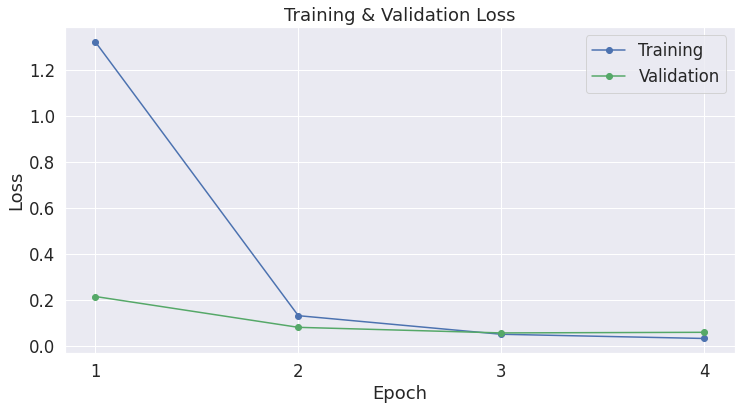

In [75]:
import matplotlib.pyplot as plt
% matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

##Performance On Test Set

In [76]:
import pandas as pd

# Load the dataset into a pandas dataframe.
test_data = pd.read_csv(DATA_TEST_PATH, delimiter=',', header=None, names=['label', 'title', 'description'])
test_data = test_data.sample(n=3000,random_state=1)


test_data['sentence'] = test_data['title']+test_data['description']


test_data['label'] = (test_data['label'] -1 ) # the class labels to start at 0

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(test_data.shape[0]))

Number of test sentences: 3,000



In [77]:
test_data

,label,title,description,sentence
6670,1,Myanmar International School,Myanmar International School (MIS) is an inde...,Myanmar International School Myanmar Internati...
49567,9,Simoides,Simoides is a genus of 7 species of Afrotropi...,Simoides Simoides is a genus of 7 species of A...
50796,10,Octomeria juncifolia,Octomeria juncifolia is a species of orchid e...,Octomeria juncifolia Octomeria juncifolia is a...
22310,4,Ruth Dreifuss,Ruth Dreifuss (born 9 January 1940 in St. Gal...,Ruth Dreifuss Ruth Dreifuss (born 9 January 19...
54037,10,Frasera caroliniensis,Frasera caroliniensis commonly known as Ameri...,Frasera caroliniensis Frasera caroliniensis co...
...,...,...,...,...
23225,4,Mia L. Jones,Mia L. Jones (born April 26 1968) is a Democr...,Mia L. Jones Mia L. Jones (born April 26 1968)...
9409,1,Lowpoint-Washburn High School,Lowpoint-Washburn Junior/Senior High School i...,Lowpoint-Washburn High School Lowpoint-Washbur...
43159,8,Pocerski Pričinović,Pocerski Pričinović (Serbian Cyrillic: Поцерс...,Pocerski Pričinović Pocerski Pričinović (Serbi...
7670,1,Kerala Agricultural University,Kerala Agricultural University (KAU) is the p...,Kerala Agricultural University Kerala Agricult...


In [78]:


# Create sentence and label lists
sentences = test_data.sentence.values
labels = test_data.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = args.max_seq_length,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                        truncation=True
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = args.batch_size  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

## Evaluate on Test Set

In [79]:

t0 = time.time()

model.eval()

eval_loss, eval_accuracy = 0, 0
nb_eval_steps, nb_eval_examples = 0, 0

for step, batch in enumerate(prediction_dataloader):
    if step % 100 == 0 and not step == 0:
        elapsed = format_time(time.time() - t0)
        print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(prediction_dataloader), elapsed))

    batch = tuple(t.to(device) for t in batch)
    
    b_input_ids, b_input_mask, b_labels = batch
    
    with torch.no_grad():     
        outputs = model(b_input_ids, 
                        token_type_ids=None, 
                        attention_mask=b_input_mask)
    
    logits = outputs[0]

    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    tmp_eval_accuracy = flat_accuracy(logits, label_ids)
    eval_accuracy += tmp_eval_accuracy
    nb_eval_steps += 1

print("")
print("Accuracy: {0:.2f}".format(eval_accuracy/nb_eval_steps))
print("Test took: {:}".format(format_time(time.time() - t0)))


Accuracy: 0.99
Test took: 0:00:49
